In [22]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
import pandas as pd 
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

2.4.1


In [4]:
!pip install torch_geometric

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)


In [2]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

In [6]:
dataset = KarateClub()
print('Dataset properties')
print('==============================================================')
print(f'Dataset: {dataset}') #This prints the name of the dataset
print(f'Number of graphs in the dataset: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') #Number of features each node in the dataset has
print(f'Number of classes: {dataset.num_classes}') #Number of classes that a node can be classified into


#Since we have one graph in the dataset, we will select the graph and explore it's properties

data = dataset[0]
print('Graph properties')
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}') #Number of nodes in the graph
print(f'Number of edges: {data.num_edges}') #Number of edges in the graph
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}') # Average number of nodes in the graph
print(f'Contains isolated nodes: {data.has_isolated_nodes()}') #Does the graph contains nodes that are not connected
print(f'Contains self-loops: {data.has_self_loops()}') #Does the graph contains nodes that are linked to themselves
print(f'Is undirected: {data.is_undirected()}') #Is the graph an undirected graph

Dataset properties
Dataset: KarateClub()
Number of graphs in the dataset: 1
Number of features: 34
Number of classes: 4
Graph properties
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


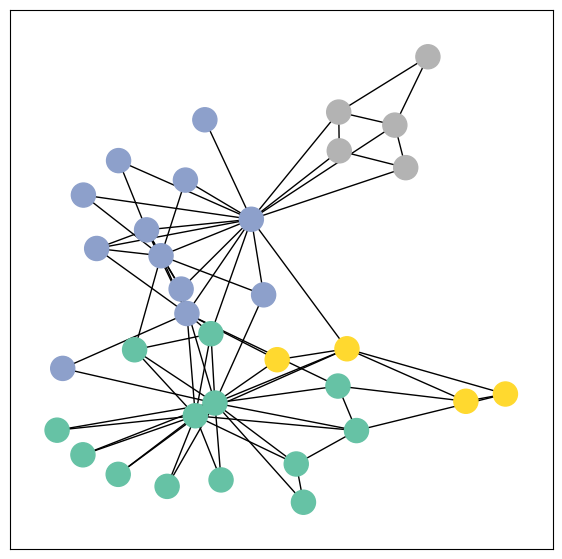

In [8]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

Implementing a Graph Neural Network

For this notebook, we will use a simple **GNN** which is the **Graph Convolution Network** (GCN) layer. Our GNN is defined by stacking three graph convolution layers, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away). In addition, the GCNConv layers reduce the node feature dimensionality to 2 , i.e., 34→4→4→2 . Each GCNConv layer is enhanced by a tanh non-linearity. We then apply a linear layer which acts as a classifier to map the nodes to 1 out of the 4 possible classes

In [26]:
dataset.num_classes

4

In [27]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(2024)
        self.conv1 = GCNConv(dataset.num_features, 4)   # dataset.num_features = 34
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)    #dataset.num_classes = 4

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [28]:
model.parameters()

<generator object Module.parameters at 0x16891fbc0>

Training of the Network Model

To train the network, we will use the CrossEntropyLoss for the loss function and Adam as the gradient optimizer

In [29]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()  #Initialize the CrossEntropyLoss function.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Initialize the Adam optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 0, Loss: 1.4753060340881348
Epoch: 1, Loss: 1.458571195602417
Epoch: 2, Loss: 1.4422260522842407
Epoch: 3, Loss: 1.4263232946395874
Epoch: 4, Loss: 1.4110620021820068
Epoch: 5, Loss: 1.3966578245162964
Epoch: 6, Loss: 1.383176326751709
Epoch: 7, Loss: 1.370532751083374
Epoch: 8, Loss: 1.3585833311080933
Epoch: 9, Loss: 1.3471604585647583
Epoch: 10, Loss: 1.3360835313796997
Epoch: 11, Loss: 1.3251866102218628
Epoch: 12, Loss: 1.3143351078033447
Epoch: 13, Loss: 1.3034241199493408
Epoch: 14, Loss: 1.292372465133667
Epoch: 15, Loss: 1.281125783920288
Epoch: 16, Loss: 1.269672155380249
Epoch: 17, Loss: 1.2580456733703613
Epoch: 18, Loss: 1.2463059425354004
Epoch: 19, Loss: 1.234511375427246
Epoch: 20, Loss: 1.2226777076721191
Epoch: 21, Loss: 1.2107253074645996
Epoch: 22, Loss: 1.1984387636184692
Epoch: 23, Loss: 1.1854734420776367
Epoch: 24, Loss: 1.1714386940002441
Epoch: 25, Loss: 1.1560239791870117
Epoch: 26, Loss: 1.1390984058380127
Epoch: 27, Loss: 1.1207271814346313
Epoch: 28

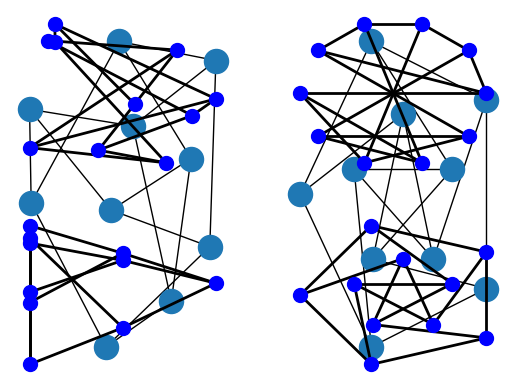

In [30]:
G = nx.petersen_graph()
plt.subplot(121)
nx.draw(G, with_labels=False, font_weight='bold')
plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=False, font_weight='bold')

options = {
   'node_color': 'blue',
   'node_size': 100,
   'width': 2,
}
plt.subplot(221)
nx.draw_random(G, **options)
plt.subplot(222)
nx.draw_circular(G, **options)
plt.subplot(223)
nx.draw_spectral(G, **options)
plt.subplot(224)
nx.draw_shell(G, nlist=[range(5,10), range(5)], **options)